## Extraction of 5 dominant colors and adjust the contrast

Unsupervised K-Means clustering was applied 
using 'sklearn' library.

---

For reading image data, 'cv2' was used.

---

'Matplotlib', on the other hand, was used for visualization purpose.



---

This part of the code is used to extract the 5 dominant colors from the image

In [62]:
# Storing image path
dir = '/content/Photo-3.jpg'

[[ 19  12   7]
 [198  64  31]
 [232 146 103]
 [ 83  46  22]
 [ 19  25  50]]


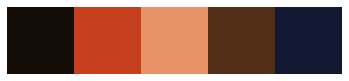

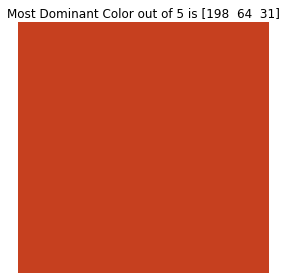

In [63]:
#Necessary Modules
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# 'colorfulness' function is used to compute the index of given RGB combination derived from image
# Parameters: 'r' means RED Channel, 'b' means BLUE Channel, 'g' means GREEN Channel
def colorfulness(r, g, b):
        rg = np.absolute(r - g)
        yb = np.absolute(0.5 * (r + g) - b)

        # Compute the mean and standard deviation of both `rg` and `yb`.
        rg_mean, rg_std = (np.mean(rg), np.std(rg))
        yb_mean, yb_std = (np.mean(yb), np.std(yb))

        # Combine the mean and standard deviations.
        std_root = np.sqrt((rg_std ** 2) + (yb_std ** 2))
        mean_root = np.sqrt((rg_mean ** 2) + (yb_mean ** 2))

        # Returning the index of given RGB combination
        return std_root + (0.3 * mean_root)

# 'find_histogram' function creates a histogram of the given image
# Parameters: 'clt' means the clusters extracted by KMeans algorithm
def find_histogram(clt):
        num_labels = np.arange(0, len(np.unique(clt.labels_)) + 1)
        hist, _ = np.histogram(clt.labels_, bins=num_labels)

        hist = hist.astype('float')
        hist /= hist.sum()

        # It returns the values of the histogram
        return hist

# Number of clusters; 5 means 5 colors from the given image will be extracted
clusters = 5
# Converting image to array from the directory we passed earlier
image = cv2.imread(dir)
# CV2 library reads images as BGR. Therefore, it converts the BGR channels to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Reshaping images from 2D to 1D
img = image.reshape((image.shape[0] * image.shape[1], 3))
# 'kmeans' object creation out of 'Kmeans' class specifying the clusters
kmeans = KMeans(n_clusters = clusters)
# Passing the image to algorithm
kmeans.fit(img)
# histogram
hist = find_histogram(kmeans)
# Clusters' centroids returned by the algorithm
COLORS = kmeans.cluster_centers_
# Converting the FLOATING VALUE to INT; Since, RGB values can't be FLOATING POINT
colors = COLORS.astype(int)
# Printing centroids value
print(colors)
#Plotting the centroids value (Converting array to dominant colors)
fig = plt.imshow([colors])
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
# Saving 5 dominant colors
#plt.savefig('/content/foo.png', bbox_inches='tight', pad_inches = 0)
# Shows the 5 dominant colors
plt.show()

# Passing 5 dominant colors RGB channel to calculate the index
colorfulness = [colorfulness(color[0], color[1], color[2]) for color in COLORS]
max_colorful = np.max(colorfulness)

# Tolerance for a colorful color.
color_tol = 5
plot = True

# If there's no colorful colors found in the image, a grey color is returned
if max_colorful < color_tol:
  best_color = [230, 230, 230]
else:
  best_color = COLORS[np.argmax(colorfulness)]

# Plotting the most dominant color out of 5 color palette
if plot:
  bar = np.zeros((50, 300, 3), dtype='uint8')
  square = np.zeros((50, 50, 3), dtype='uint8')
  start_x = 0

  for (percent, color) in zip(hist, COLORS):
    end_x = start_x + (percent * 300)
    bar[:, int(start_x):int(end_x)] = color
    start_x = end_x
    square[:] = best_color


plt.title('Most Dominant Color out of 5 is {}'.format(square[0][0]))
plt.axis('off')
plt.imshow(square)
plt.tight_layout()
plt.plot()
plt.show(block=False)

# Seperating the channels for converting them into HSL for further tweaking
best = square[0][0]
r1 = best[0]
g1 = best[1]
b1 = best[2]

This part of the code is used to tweak the lightness from HLS aka HSL value to achieve the suitable color for later use

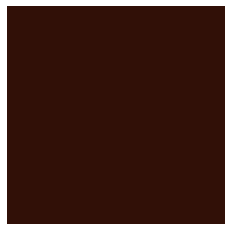

In [64]:
# Necessary modules to convert RGB channel to HLS and vice-versa
from colorsys import rgb_to_hls, hls_to_rgb

# 'adjust_color' function adjusts the contrast of the image
# Parameters: 'r': RED CHANNEL, 'g': GREEN CHANNEL, 'b': BLUE CHANNEL and 
#'factor': Percentage of lightness to control the contrast (You can tweak this value
# to achieve the desired color)

def adjust_color(r, g, b, factor):
    # Converting the RGB channels to HLS
    h, l, s = rgb_to_hls(r / 255.0, g / 255.0, b / 255.0)
    # Applying factor to the lightness value
    l = max(min(l * factor, 1.0), 0.0)
    # Converting back the HSL value to RGB
    r, g, b = hls_to_rgb(h, l, s)
    # Returning the RGB channel
    return int(r * 255), int(g * 255), int(b * 255)

# Invoking the 'adjut_color' function
adjusted = adjust_color(r1, g1, b1, 0.25)
# Converting into array
adjusted = np.array([adjusted])
# Plotting the final dominant color
plt.axis('off')
plt.imshow([adjusted])

## 3D Visualization of the 5 dominant colors in a image

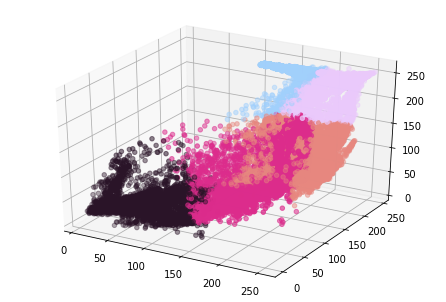

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as color
import numpy as np
from collections import Counter
import pandas as pd
import math
from sklearn.cluster import KMeans
from PIL import Image
import webcolors
import json
import argparse
import sys
sys.argv=['']
del sys

with open('/content/colors.json') as clr:
    color_dict = json.load(clr)

parser = argparse.ArgumentParser()
parser.add_argument("--clusters", help="No. of clusters")
parser.add_argument("--imagepath", help="Path to input image")

args = parser.parse_args()

# Change the directory to your need to refer an image
IMG_PATH = args.imagepath if args.imagepath else dir
CLUSTERS = args.clusters if args.clusters else 5
WIDTH = 256
HEIGHT = 256

def closest_colour(requested_colour):
    '''
    We are basically calculating euclidean distance between our set of RGB values
    with all the RGB values that are present in our JSON. After that, we are looking 
    at the combination RGB (from JSON) that is at least distance from input
    RGB values, hence finding the closest color name.
    '''
    min_colors = {}
    for key, name in color_dict['color_names'].items():
        r_c, g_c, b_c = webcolors.hex_to_rgb("#"+key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colors[math.sqrt(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

def get_colour_name(requested_colour):
    '''
    In this function, we are converting our RGB set to color name using a third 
    party module "webcolors".
    
    RGB set -> Hex Code -> Color Name
    
    By default, it looks in CSS3 colors list (which is the best). If it cannot find
    hex code in CSS3 colors list, it raises a ValueError which we are handling
    using our own function in which we are finding the closest color to the input
    RGB set.
    '''
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

def calculate_new_size(image):
    '''
    We are resizing the image (one of the dimensions) to 128 px and then, scaling the
    other dimension with same height by width ratio.
    '''
    if image.width >= image.height:
        wperc = (WIDTH / float(image.width))
        hsize = int((float(image.height) * float(wperc)))
        new_width, new_height = WIDTH, hsize
    else:
        hperc = (HEIGHT / float(image.height))
        wsize = int((float(image.width) * float(hperc)))
        new_width, new_height = wsize, HEIGHT
    return new_width, new_height

def rgb_to_hex(rgb):
    '''
    Converting our rgb value to hex code.
    '''
    hex = color.to_hex([int(rgb[0])/255, int(rgb[1])/255, int(rgb[2])/255])
    
    return hex

def findColorName(rgb):
    '''
    Finding color name :: returning hex code and nearest/actual color name
    '''
    aname, cname = get_colour_name((int(rgb[0]), int(rgb[1]), int(rgb[2])))
    hex = color.to_hex([int(rgb[0])/255, int(rgb[1])/255, int(rgb[2])/255])
    if aname is None:
        name = cname
    else:
        name = aname
    return hex, name
    
    
def TrainKMeans(img):
    new_width, new_height = calculate_new_size(img)
    image = img.resize((new_width, new_height), Image.ANTIALIAS)
    img_array = np.array(image)
    img_vector = img_array.reshape((img_array.shape[0] * img_array.shape[1], 3))

    kmeans = KMeans(n_clusters = CLUSTERS, random_state=0)
    labels = kmeans.fit_predict(img_vector)
    
    hex_colors = [rgb_to_hex(center) for center in kmeans.cluster_centers_]
    color_name = {}
    for c in kmeans.cluster_centers_:
        h, name = findColorName(c)
        color_name[h] = name
        
    img_cor = [[*x] for x in img_vector]
    '''
    img_cor is a nested list of all the coordinates (pixel -- RGB value) present in the
    image
    '''
    cluster_map = pd.DataFrame()
    cluster_map['position'] = img_cor
    cluster_map['cluster'] = kmeans.labels_
    cluster_map['x'] = [x[0] for x in cluster_map['position']]
    cluster_map['y'] = [x[1] for x in cluster_map['position']]
    cluster_map['z'] = [x[2] for x in cluster_map['position']]
    cluster_map['color'] = [hex_colors[x] for x in cluster_map['cluster']]
    cluster_map['color_name'] = [color_name[x] for x in cluster_map['color']]
    return cluster_map, kmeans
    
def plotColorClusters(img):
    cluster_map, kmeans = TrainKMeans(img)
    fig = plt.figure()
    ax = Axes3D(fig)
    
    # grouping the data by color hex code and color name to find the total count of
    # pixels (data points) in a particular cluster
    mydf = cluster_map.groupby(['color', 'color_name']).agg({'position':'count'}).reset_index().rename(columns={"position":"count"})
    mydf['Percentage'] = round((mydf['count']/mydf['count'].sum())*100, 1)
    
    # Plotting a scatter plot for all the clusters and their respective colors
    ax.scatter(cluster_map['x'], cluster_map['y'], cluster_map['z'], color = cluster_map['color'])
    plt.show()

img = Image.open(IMG_PATH)
plotColorClusters(img)